## This automated portfolio system uses an existing model for stock returns; the price momentum alpha generator.
## An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
## I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


C:\Users\jeanb\AppData\Local\Temp\ipykernel_12504\2988629714.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed

3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [3]:
sp500.tail(1) #Adjusted Close

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-27,132.899994,15.635,181.0979,178.145004,151.820007,118.749901,86.830002,377.454987,552.775024,189.389999,...,103.620003,58.465,104.169998,33.610001,125.730003,137.960007,126.839996,277.029999,39.007,198.720001


In [4]:
# Define the time period and lag, can be changed to any number and code will work
time_period = 1260  # 5 years
lag = 20 # lag of 20 days


## Momentum Factors:
 ### Parameter for calculation is used for the backtest. The backtest will run 5 years but can be changed as long as there is sufficient data downloaded.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years. It's for backtesting.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors (5 years prior to current date) (20 day lag)

Aggregate factors with z-score calculation. Z-scores will determine the long basket and short basket.

In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.049869,38.100260,6.437526,0.129053,1.052956e+05
AAL,-0.015386,44.596974,-7.011737,-0.047182,9.202060e+07
AAPL,0.125379,58.004420,14.699912,0.307486,3.087520e+07
ABBV,0.081353,39.324617,10.073472,0.182539,-9.025890e+05
ABNB,NaN,35.321033,-4.785297,-0.032522,1.574519e+06
...,...,...,...,...,...
YUM,0.030062,36.208712,3.423431,0.068825,4.746639e+04
ZBH,0.004375,33.279295,-0.479601,0.026241,-9.424496e+04
ZBRA,0.059524,55.851762,3.278750,0.130926,-1.385958e+05


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    41.911038
MRNA    19.514252
NVDA    17.758653
ENPH    15.829462
NVR     15.239485
BLDR     9.890752
CMG      9.626704
AZO      9.375025
AMD      9.234403
FCX      8.319743
dtype: float64

Short Basket:
Ticker
BXP    -5.095951
VZ     -5.102907
PARA   -5.276585
WBA    -5.436562
ILMN   -5.543625
VTRS   -5.943875
WBD    -5.966440
BAX    -6.195958
FIS    -6.328392
VFC    -7.860180
dtype: float64


## Creating the Back-Tested Baskets

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.869075
NVDA    17.193537
AMD     15.962100
CZR     13.368311
ETSY    13.341220
NFLX    12.386641
ALGN    11.334983
PAYC    11.067270
ENPH     8.197185
TTWO     8.155071
dtype: float64
Short Basket Past 5 Years:
Ticker
F      -5.025132
BBWI   -5.063778
BEN    -5.187909
HWM    -5.248851
APA    -5.486010
CMG    -5.544114
MCK    -5.592337
SLB    -5.675977
EQT    -6.505897
GE     -6.737773
dtype: float64


## Cumulative Returns

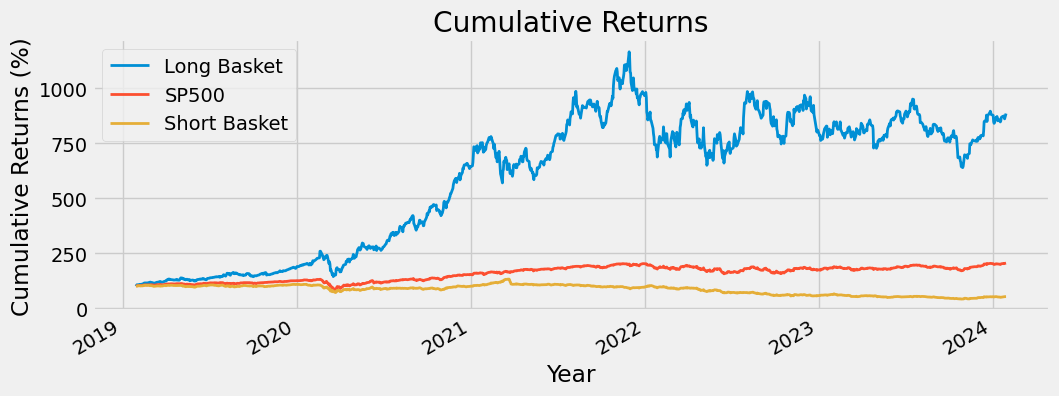

In [20]:
def calculate_cumulative_returns(dataf): 
    returns = dataf.pct_change()
    cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# Back Tested Cumulative Returns

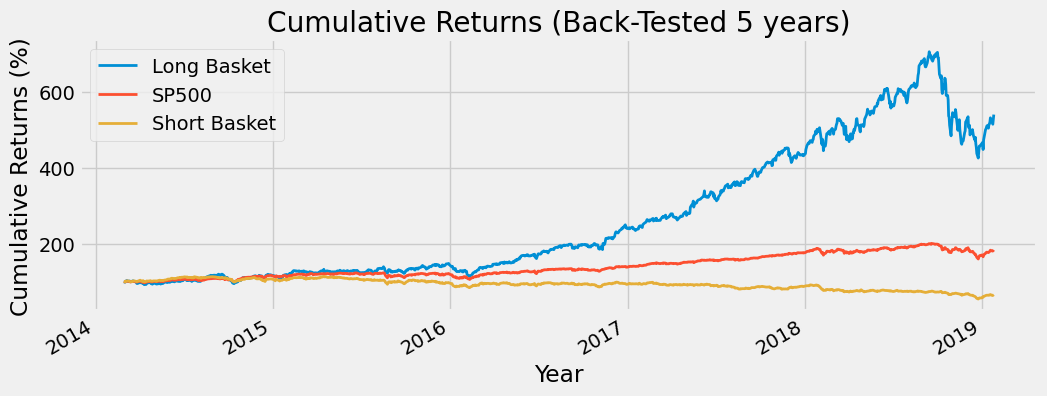

In [21]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

# As of most current day:

In [12]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
884.5974794472805
Short Basket Cumulative Returns: Most current day
53.12786799752153
SP500 Cumulative Returns: Most current day
205.4884804371276


In [13]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-02-27 Long Basket has outperformed the SP500 by 679.108999010153 percentage points
As of 2024-02-27 Short Basket has underperformed the SP500 by -152.3606124396061 percentage points


## Monthly Potfolio Returns

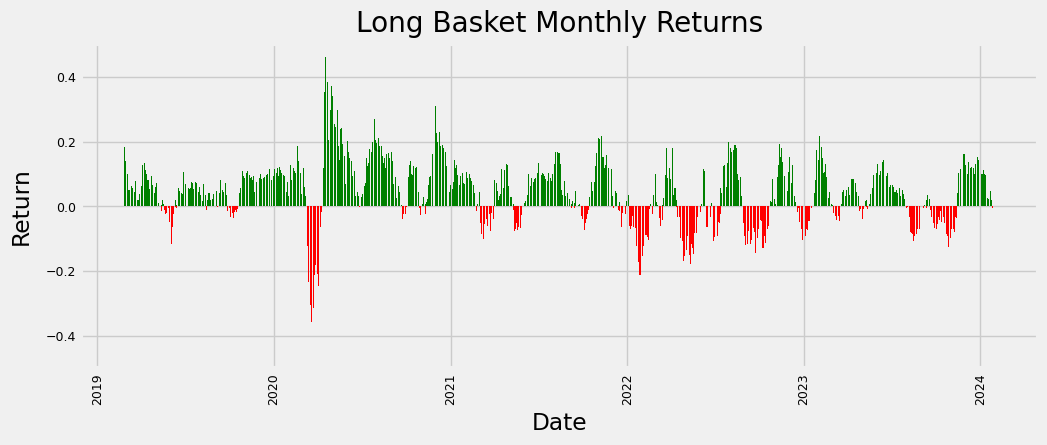

In [14]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

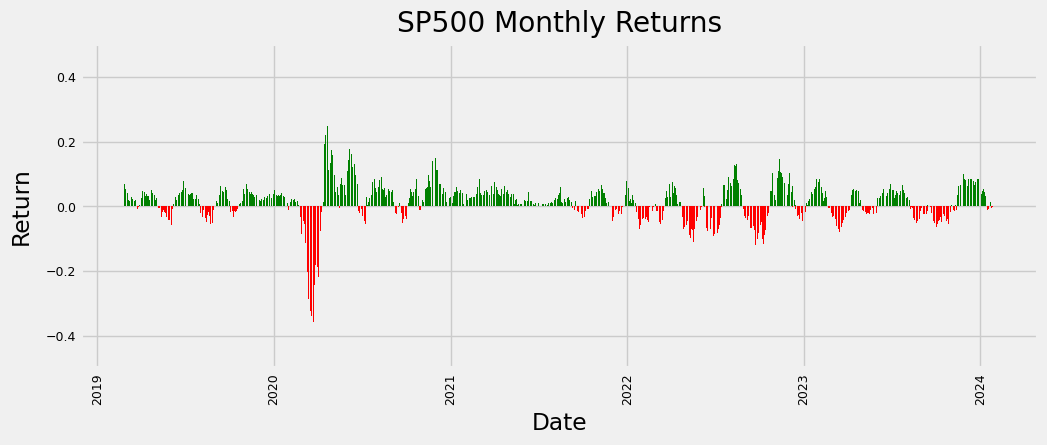

In [15]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

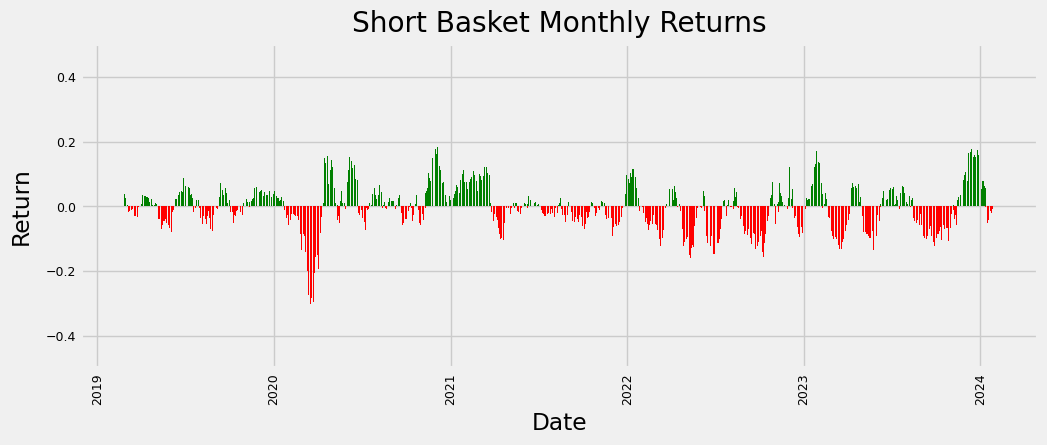

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Monthly return for long picks vs short picks vs SP500

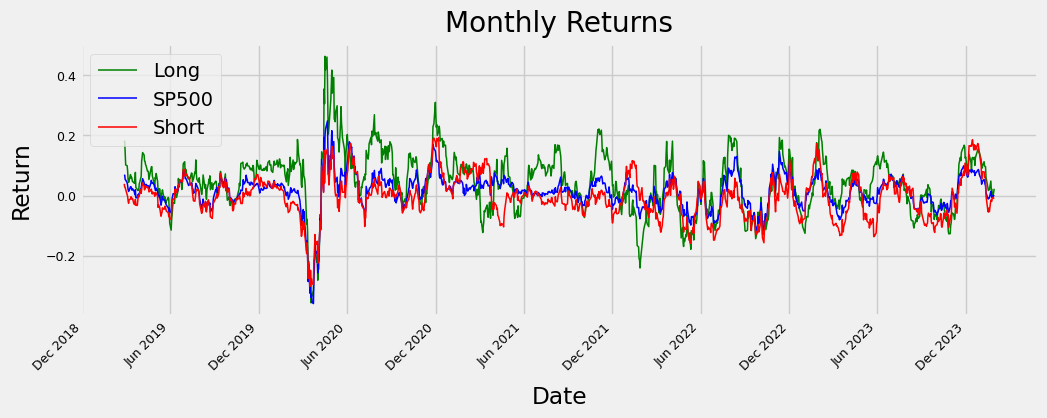

In [17]:
# Three plots 
plt.style.use('fivethirtyeight')
long_monthly_returns.plot(figsize=(11,4), label = 'Long', color = 'g', lw=1.1)
monthly_returns.plot(figsize=(11,4), label = 'SP500', color ='b', lw = 1.1)
short_monthly_returns.plot(figsize=(11,4),label= 'Short', color = 'r', lw=1.1)

# Plot configurations 
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y',))
plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=9)
plt.ylabel('Return',labelpad=9)
plt.xlabel('Date',labelpad=9)
plt.title('Monthly Returns',pad=9)
plt.show()

# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [35]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-14] # slicing out the last 14 characters (current directory)

target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [36]:
ef = EfficientFrontier(sp500[long_basket.index])
ef.calculate_portfolio() #Printing Annual Returns

Ticker
TSLA    1.398573
MRNA    1.582344
NVDA    1.623680
ENPH    1.590833
NVR     1.231600
BLDR    1.437549
CMG     1.212803
AZO     1.200750
AMD     1.549278
FCX     1.170931
dtype: float64


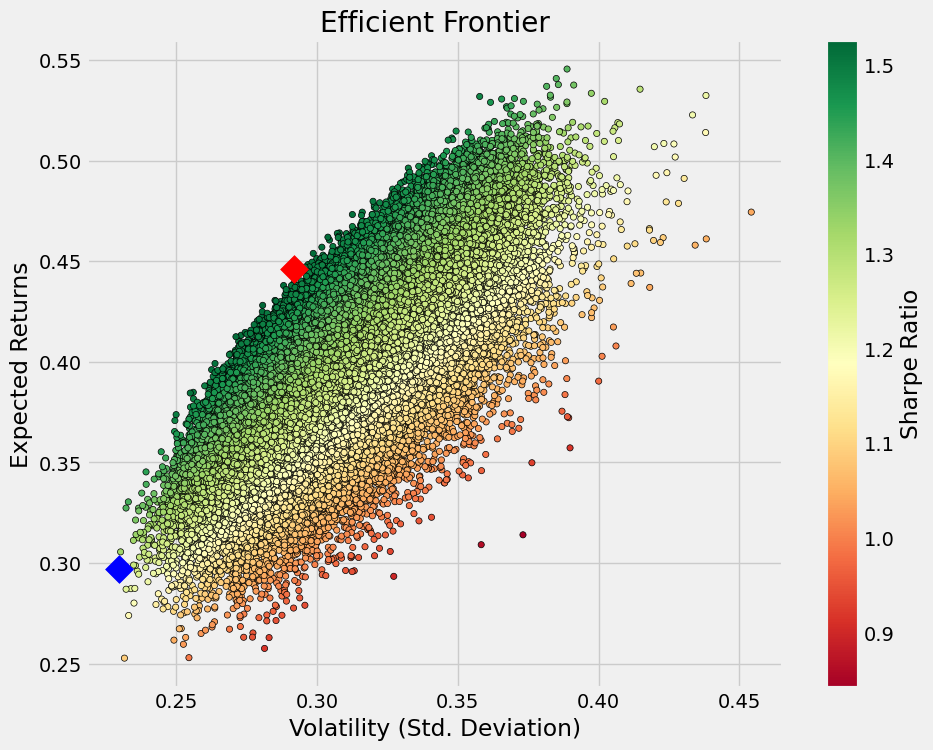

In [37]:
ef.plot_frontier()

In [38]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.296785                  0.445925
Volatility                        0.229561                  0.292024
Sharpe Ratio                      1.292836                  1.527013
TSLA Weight                       0.003314                  0.004864
MRNA Weight                       0.112095                  0.139973
NVDA Weight                       0.093934                  0.244086
ENPH Weight                       0.000712                  0.040736
NVR Weight                        0.329809                  0.031741
BLDR Weight                       0.005461                  0.135134
CMG Weight                        0.058285                  0.071386
AZO Weight                        0.300035                  0.209264
AMD Weight                        0.008729                  0.109689
FCX Weight                        0.087626                  0.013126
